# Analysis on Web Novel Data

### Part 1: Regression Analysis of Title Length's Effect on the Popularity
In this part, I will use robust linear regression and quantile regression to estimate title length’s effect on the number of books and the average score of web novels.

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
from statsmodels.formula.api import rlm
from statsmodels.formula.api import quantreg
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
pd.options.display.max_columns = None
warnings.filterwarnings("ignore")
sns.set_theme()

In [2]:
df = pd.read_excel('japanesewebnovel.xlsx')
df['No_update'] = np.where(((df['Status'] == 'On Going') & (df['Latest_Update'] < '2020-10-28')) , 1, 0)
df.head()

,Title,Status,Parts,Abstract,Publish Date,Author,ID,Sub_Genre,Genre,Latest_Update,Word_Count,Weekly_Viewers,Reviews,Bookmarks,Ratings,Total_Scores,Keywords,Title_Length,Abstract_Length,Average_Score,No_update
0,満月の騎士,Completed,25,どこかで聞いたことのあるような名前の主人公はある時、幽霊の憑いた木刀を手にいれる。さて、これ...,2007-01-01,雨月,N3460B,Others,Others,2007-04-29,82039,100,0,3,2.0,12.0,霊 シリアス コメディ ハッピーエンド らぶらぶ 高校生 現代(モダン),5,76,6.0,0
1,エイト・アイズ,On Going,24,狐宮龍弥は天才である。天才であるが故に子供のころから色々と危険な目にもあった。なので、護身術...,2007-01-01,サカガミ ヤスヒロ,N3458B,Others,Others,2007-07-02,47311,100,0,0,0.0,0.0,目 ８ 悪霊 霊 妖怪 高校生 現代(モダン) 霊界/地獄/天国 残酷な描写有り,7,106,NaN,1
2,フェア,On Going,33,自分の村を失った少年や大人が、教会で新たな仲間と出会い、世界を守るために闇と戦っていく…悲し...,2007-01-01,藍,N3456B,Others,Others,2007-11-09,94887,100,0,0,0.0,0.0,戦争 ファンタジー 少年 十字架 双子,3,65,NaN,1
3,SPhinX,On Going,7,SPhinxとは、SP(SecurityPolice：要人警護、警護官)とスフィンクス（伝説...,2007-01-02,瑛彪・玄彪,N3483B,High Fantasy,Fantasy,2007-12-28,9244,100,0,0,1.0,2.0,ＳＰ 中学生 高校生 太古 現代(モダン),6,82,2.0,1
4,フェチ性人格障害,On Going,24,誰でも潜む欲求。普通に生活し普通に生きてきたはずの男性や女性のふとした事からのフェチシズム。...,2007-01-02,かずん。,N3485B,Others,Others,2007-01-28,27414,100,0,0,0.0,0.0,R15 精神病 解離 人格障害 フェチシズム,8,93,NaN,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400373 entries, 0 to 400372
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Title            400373 non-null  object 
 1   Status           400373 non-null  object 
 2   Parts            400373 non-null  int64  
 3   Abstract         400373 non-null  object 
 4   Publish Date     400373 non-null  object 
 5   Author           400366 non-null  object 
 6   ID               400373 non-null  object 
 7   Sub_Genre        400373 non-null  object 
 8   Genre            400373 non-null  object 
 9   Latest_Update    400373 non-null  object 
 10  Word_Count       400373 non-null  int64  
 11  Weekly_Viewers   400373 non-null  int64  
 12  Reviews          400373 non-null  int64  
 13  Bookmarks        400373 non-null  int64  
 14  Ratings          396972 non-null  float64
 15  Total_Scores     396972 non-null  float64
 16  Keywords         388765 non-null  obje

In [4]:
df.agg({
    "Title_Length": ["min", "max", "median", "mean", "std"],
    "Bookmarks": ["min", "max", "median", "mean", "std"],
    "Average_Score": ["min", "max", "median", "mean", "std"],
    "Word_Count": ["min", "max", "median", "mean", "std"],
    "Weekly_Viewers": ["min", "max", "median", "mean", "std"],
}).round(2)

,Title_Length,Bookmarks,Average_Score,Word_Count,Weekly_Viewers
min,1.00,0.00,2.00,0.00,100.00
max,100.00,283931.00,10.00,24362544.00,426771.00
median,11.00,1.00,8.50,11237.00,100.00
mean,14.00,230.55,8.04,63775.16,178.07
std,10.72,2617.87,1.86,203427.00,2205.72


### Robust Linear Regression 
Since some authors might ask their friends to bookmark their web novels and leave a good rating while some do not, I exclude the outliers with 20 or fewer bookmarks and ratings in the robust linear regression model.

In [5]:
# dummy variabes for genres
dummy = pd.get_dummies(df['Genre'])
dummy = dummy.rename(columns={"Sci-fi": "Sci_fi"})
df = pd.concat([df, dummy], axis=1)
df.drop(columns=['Others'])

# interaction terms (title_length * genre)
df['tlength_fantasy'] = df['Title_Length']*df['Fantasy']
df['tlength_literature'] = df['Title_Length']*df['Literature']
df['tlength_romance'] = df['Title_Length']*df['Romance']
df['tlength_scifi'] = df['Title_Length']*df['Sci_fi']

In [6]:
df1 = df[df['Bookmarks'] >= 50]
model1 = rlm('Bookmarks ~ Title_Length + Fantasy + Literature + Romance + Sci_fi + Parts',data=df1).fit()
model2 = rlm('Bookmarks ~ Title_Length + Fantasy + Literature + Romance + Sci_fi + Parts + tlength_fantasy + tlength_literature + tlength_romance + tlength_scifi',data=df1).fit()

df2 = df[df['Ratings'] >= 30]
model3 = rlm('Average_Score ~ Title_Length + Fantasy + Literature + Romance + Sci_fi + Parts',data=df2).fit()
model4 = rlm('Average_Score ~ Title_Length + Fantasy + Literature + Romance + Sci_fi + Parts + tlength_fantasy + tlength_literature + tlength_romance + tlength_scifi',data=df2).fit()

stargazer = Stargazer([model1, model2, model3, model4])
stargazer.rename_covariates({'tlength_fantasy': 'Title length x Fantasy',
                             'tlength_literature': 'Title length x Literature',
                             'tlength_romance': 'Title length x Romance',
                             'tlength_scifi': 'Title length x Sci-fi'})
stargazer.covariate_order(['Intercept','Title_Length','Parts','Fantasy','Literature','Romance','Sci_fi','tlength_fantasy','tlength_literature','tlength_romance','tlength_scifi'])
stargazer.custom_columns(['Bookmarks','Bookmarks','Average Score','Average Score'], [1, 1, 1, 1])
HTML(stargazer.render_html())

In [7]:
df1 = df[df['Bookmarks'] >= 20]
model1 = rlm('Bookmarks ~ Title_Length + Fantasy + Literature + Romance + Sci_fi + Parts',data=df1).fit()
model2 = rlm('Bookmarks ~ Title_Length + Fantasy + Literature + Romance + Sci_fi + Parts + tlength_fantasy + tlength_literature + tlength_romance + tlength_scifi',data=df1).fit()

df2 = df[df['Ratings'] >= 20]
model3 = rlm('Average_Score ~ Title_Length + Fantasy + Literature + Romance + Sci_fi + Parts',data=df2).fit()
model4 = rlm('Average_Score ~ Title_Length + Fantasy + Literature + Romance + Sci_fi + Parts + tlength_fantasy + tlength_literature + tlength_romance + tlength_scifi',data=df2).fit()

stargazer = Stargazer([model1, model2, model3, model4])
stargazer.rename_covariates({'tlength_fantasy': 'Title length x Fantasy',
                             'tlength_literature': 'Title length x Literature',
                             'tlength_romance': 'Title length x Romance',
                             'tlength_scifi': 'Title length x Sci-fi'})
stargazer.covariate_order(['Intercept','Title_Length','Parts','Fantasy','Literature','Romance','Sci_fi','tlength_fantasy','tlength_literature','tlength_romance','tlength_scifi'])
stargazer.custom_columns(['Bookmarks','Bookmarks','Average Score','Average Score'], [1, 1, 1, 1])
HTML(stargazer.render_html())

## Quantile Regression

### Number of Bookmarks

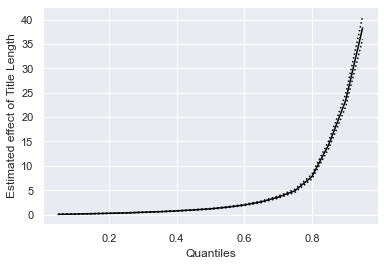

In [8]:
quantiles = np.arange(0.05, 1.00, 0.05)
def fit_model(model,q):
    res = model.fit(q=q)
    return [q, res.params["Intercept"], res.params["Title_Length"]] + res.conf_int().loc["Title_Length"].tolist()

qr_bookmark = quantreg("Bookmarks ~ Title_Length + Fantasy + Literature + Romance + Sci_fi + Parts", data=df1)
model1 = [fit_model(qr_bookmark,x) for x in quantiles]
model1 = pd.DataFrame(model1, columns=["q", "a", "b", "lb", "ub"])

plt.plot(model1.q, model1.b, label="Quantile Reg.", color = 'black')
plt.plot(model1.q, model1.ub, linestyle="dotted", color = 'black')
plt.plot(model1.q, model1.lb, linestyle="dotted", color = 'black')
plt.ylabel("Estimated effect of Title Length")
plt.xlabel("Quantiles")
plt.show()

### Average score

In [9]:
df2.Average_Score.quantile([0.1,0.25,0.5,0.75,0.9])

0.10    8.0563
0.25    8.4800
0.50    8.8571
0.75    9.1660
0.90    9.3902
Name: Average_Score, dtype: float64

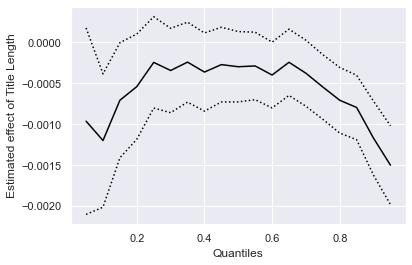

In [10]:
qr_score = quantreg("Average_Score ~ Title_Length + Fantasy + Literature + Romance + Sci_fi + Parts", data=df2)
model2 = [fit_model(qr_score,x) for x in quantiles]
model2 = pd.DataFrame(model2, columns=["q", "a", "b", "lb", "ub"])

plt.plot(model2.q, model2.b, label="Quantile Reg.", color = 'black')
plt.plot(model2.q, model2.ub, linestyle="dotted", color = 'black')
plt.plot(model2.q, model2.lb, linestyle="dotted", color = 'black')
plt.ylabel("Estimated effect of Title Length")
plt.xlabel("Quantiles")
plt.show()

## Part 2: K-NN and Logistic Regression
In this part, I will use K Nearest Neighbor and logistic regression to predict if the author has stopped updating the web novels.

In [12]:
df_ongoing = df[df['Status'] == 'On Going']
df_ongoing['No_update'].value_counts()

1    272763
0     25671
Name: No_update, dtype: int64

<AxesSubplot:ylabel='No_update'>

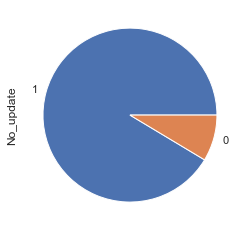

In [13]:
df_ongoing['No_update'].value_counts().plot.pie()

The majority of the ongoing novel hasn't had any update for over a year! 

In [14]:
label_encoder = LabelEncoder()
df_ongoing['Genre'] = df_ongoing[['Genre']].apply(label_encoder.fit_transform)
df_ongoing['Average_Score'] = df_ongoing['Average_Score'].replace(np.NaN, 0)
df_ongoing = df_ongoing.dropna()
x = df_ongoing[['Title_Length','Genre','Reviews','Ratings','Bookmarks']]
y = df_ongoing['No_update']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

In [15]:
from sklearn.neighbors import KNeighborsClassifier

num = []
scores = []
for i in range(1,20):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    score_knn = knn.score(X_test, y_test)
    num.append(i)
    scores.append(score_knn)
dic = dict(zip(num, scores))
k = max(dic, key=dic. get)
score_knn = max(scores)

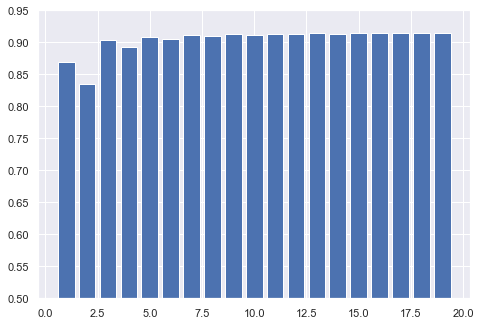

The number of neighbors that maximize the accuracy is 17 ,and its accuracy is 0.91454 .


In [16]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(num,scores)
ax.set_ylim(0.5,0.95)
plt.show()
print('The number of neighbors that maximize the accuracy is',k,',and its accuracy is',max(scores).round(5),'.')

In [17]:
from sklearn.linear_model import LogisticRegression
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train,y_train)
score_logistic = logistic_reg.score(X_test,y_test)
score_logistic

0.9136545134348137